In [1]:
#%matplotlib widget
import os
import cv2
import json
import glob
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Parameters

In [2]:
camera_name = "espcam_120_deg"
N, M = 6, 7 # Checkerboard size
images = glob.glob("calibration_images/%s/*.jpg" % (camera_name))

# Find checkerboard corners

In [3]:
objp = np.zeros((N * M, 3), np.float32)
objp[:,:2] = 5e-3 * np.mgrid[0:N, 0:M].T.reshape(-1, 2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

num_valid = 0
calibdata = []
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, approx_corners = cv2.findChessboardCorners(gray, (N, M), None)
    imgpoints = cv2.cornerSubPix(gray, approx_corners, (11,11), (-1,-1), criteria) if ret else []
    print(fname, ret)
    if ret:
        num_valid += 1
    
    calibdata.append({
        "img": img,
        "imgpoints": imgpoints,
        "objpoints": objp if ret else [],
    })
print("Total valid: %d/%d" % (num_valid, len(images)))

calibration_images/espcam_120_deg\cold_water_meter_20210123_131246.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131309.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131325.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131338.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131451.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131459.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131534.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131542.jpg True
calibration_images/espcam_120_deg\cold_water_meter_20210123_131547.jpg True
Total valid: 9/9


# Calibrate camera

In [6]:
imgpoints = [c["imgpoints"] for c in calibdata if len(c) > 0]
objpoints = [c["objpoints"] for c in calibdata if len(c) > 0]

h,  w = calibdata[0]["img"].shape[:2]
ret, camera_matrix, distortion_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)

print(ret)
print(camera_matrix)
print(distortion_coefs)

new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, distortion_coefs, (w,h), 0.0, (w,h))
print("NEW")
print(new_camera_matrix)

0.5682431291648612
[[528.95739555   0.         413.18502259]
 [  0.         529.3236959  289.11248338]
 [  0.           0.           1.        ]]
[[-0.38551132  0.19522675  0.00470443  0.00460583 -0.05534607]]
NEW
[[441.78594971   0.         392.33062828]
 [  0.         462.87091064 292.51434401]
 [  0.           0.           1.        ]]


# Visualize

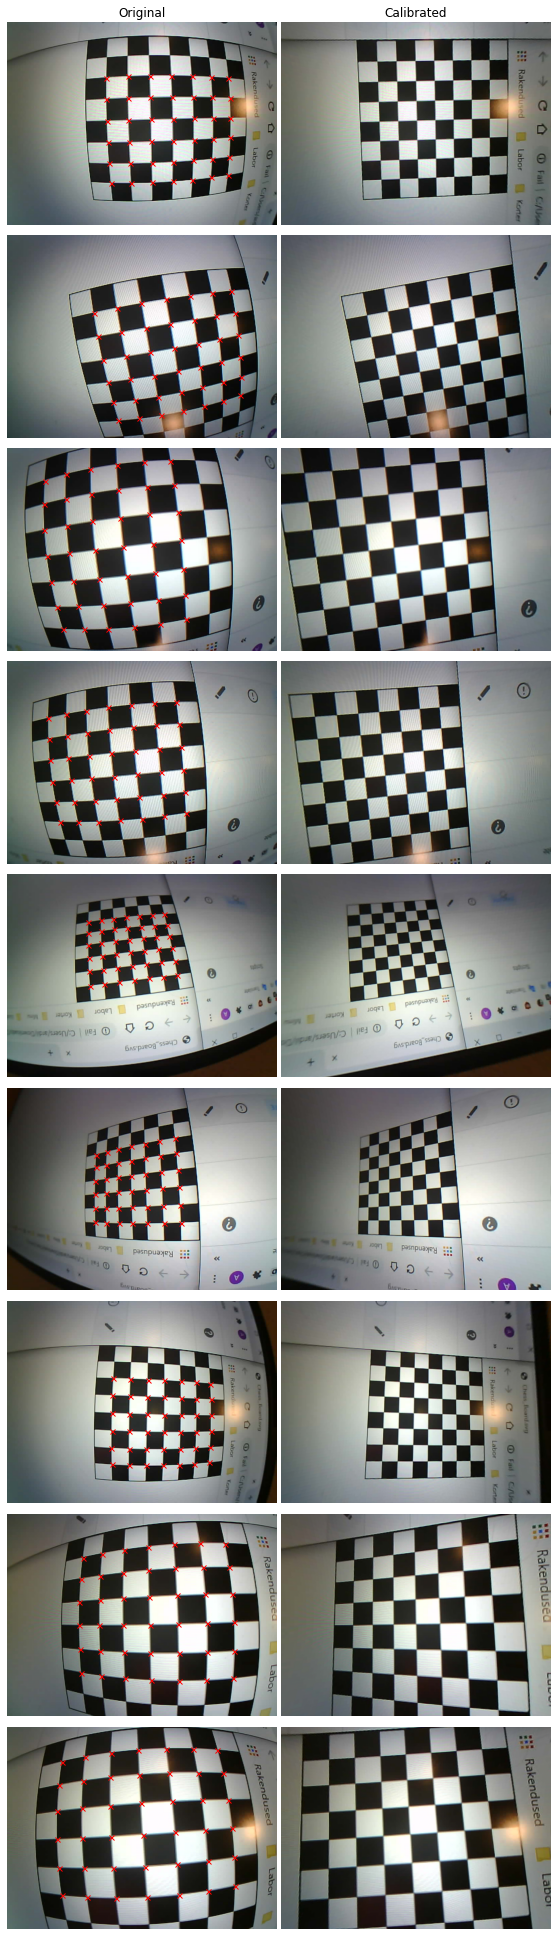

In [7]:
fig, axs = plt.subplots(len(images), 2, figsize=(8, 3.0 * len(calibdata)))
for i, d in enumerate(calibdata):
    ax1, ax2 = axs[i]
    ax1.axis("off")
    ax1.imshow(cv2.cvtColor(d["img"], cv2.COLOR_BGR2RGB), cmap='gray')
    ax1.plot([c[0][0] for c in d["imgpoints"]], [c[0][1] for c in d["imgpoints"]], "x", ms=5.0, lw=1.0, color="r")
    
    corrected_img = cv2.undistort(d["img"], camera_matrix, distortion_coefs, None, new_camera_matrix)
    ax2.axis("off")
    ax2.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB), cmap='gray')
    
axs[0, 0].set_title("Original")
axs[0, 1].set_title("Calibrated")
fig.tight_layout()

# Save

In [11]:
with open(os.path.join("cameras", "%s.json" % (camera_name)), "w") as f:
    json.dump({
        "name": camera_name,
        "camera_matrix": np.ravel(camera_matrix).tolist(),
        "distortion_coefs": np.ravel(distortion_coefs).tolist(),
        "new_camera_matrix": np.ravel(new_camera_matrix).tolist(),
    }, f, indent=4)